# EuroSAT_MS – Pretrained Deep Learning Pipeline

This notebook fine-tunes the Hugging Face `Rhodham96/EuroSatCNN` multispectral classifier on the 13-channel EuroSAT dataset and prepares a Kaggle submission using the resulting deep learning model.

## 1) Environment Setup

In [57]:
!pip install -q rasterio transformers huggingface_hub accelerate

## 2) Imports & Utilities

In [58]:
from google.colab import drive
from pathlib import Path
import os, random, math, time, shutil, glob, re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, AutoModelForImageClassification, get_cosine_schedule_with_warmup
from tqdm.auto import tqdm

import rasterio


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


RANDOM_SEED = 42
set_seed(RANDOM_SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## 3) Mount Drive and Extract EuroSAT_MS

In [59]:
drive.mount('/content/drive', force_remount=True)

ZIP_PATH = "/content/drive/MyDrive/ML_HSG/EuroSAT_MS.zip"
DATA_ROOT = Path("/content/EuroSAT_MS")

if not DATA_ROOT.exists():
    print(f"Extracting dataset from {ZIP_PATH} ...")
    !unzip -q -o "$ZIP_PATH" -d "/content"
else:
    print(f"Dataset already available at {DATA_ROOT}")

print("DATA_ROOT:", DATA_ROOT.resolve())

Mounted at /content/drive
Dataset already available at /content/EuroSAT_MS
DATA_ROOT: /content/EuroSAT_MS


## 4) Collect Samples and Visualise

Detected 10 classes -> ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total samples: 27000


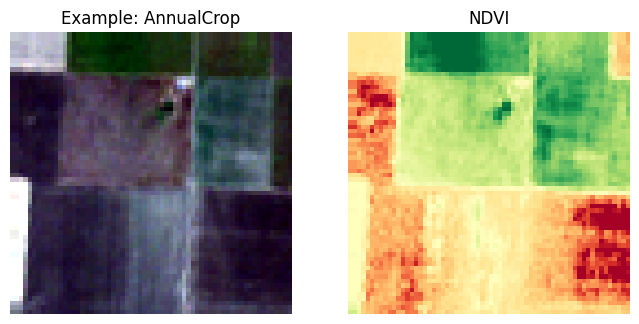

In [60]:
CLASS_NAMES = []
samples = []

if DATA_ROOT.exists():
    class_dirs = sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()])
    for d in class_dirs:
        label = len(CLASS_NAMES)
        CLASS_NAMES.append(d.name)
        for tif_path in sorted(d.glob('*.tif')):
            samples.append((tif_path, label))
else:
    raise FileNotFoundError(f"{DATA_ROOT} not found. Check ZIP_PATH and rerun the extraction cell.")

CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: name for name, idx in CLASS_TO_IDX.items()}

print(f"Detected {len(CLASS_NAMES)} classes -> {CLASS_NAMES}")
print(f"Total samples: {len(samples)}")


def pad_to_13_bands(arr: np.ndarray) -> np.ndarray:
    arr = np.asarray(arr)
    if arr.shape[0] == 13:
        return arr
    if arr.shape[0] == 12:
        zero_band = np.zeros((1, *arr.shape[1:]), dtype=arr.dtype)
        return np.concatenate([arr[:9], zero_band, arr[9:]], axis=0)
    raise ValueError(f"Expected 12 or 13 bands, got {arr.shape}")


def robust_normalize(arr: np.ndarray) -> np.ndarray:
    arr = arr.astype(np.float32, copy=False)
    out = np.empty_like(arr)
    for i in range(arr.shape[0]):
        band = arr[i]
        lo, hi = np.percentile(band, [2, 98])
        if hi > lo:
            band = (band - lo) / (hi - lo)
        else:
            min_v, max_v = band.min(), band.max()
            if max_v > min_v:
                band = (band - min_v) / (max_v - min_v)
            else:
                band = np.zeros_like(band)
        out[i] = np.clip(band, 0.0, 1.0)
    return out


def load_multispectral(path: Path) -> np.ndarray:
    with rasterio.open(path) as src:
        arr = src.read()  # (C,H,W)
    arr = pad_to_13_bands(arr)
    arr = robust_normalize(arr)
    return arr


def show_sample(path: Path, title: str = None) -> None:
    arr = load_multispectral(path)
    rgb = np.stack([arr[3], arr[2], arr[1]], axis=-1)
    ndvi = (arr[7] - arr[3]) / (arr[7] + arr[3] + 1e-6)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(np.clip(rgb, 0.0, 1.0))
    plt.title(title or path.parent.name)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(ndvi, cmap='RdYlGn')
    plt.title('NDVI')
    plt.axis('off')
    plt.show()


if samples:
    show_sample(samples[0][0], title=f"Example: {samples[0][0].parent.name}")

## 5) Train / Validation / Test Split

In [61]:
paths = np.array([str(p) for p, _ in samples])
labels = np.array([label for _, label in samples])
indices = np.arange(len(samples))

idx_trainval, idx_test = train_test_split(
    indices,
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=labels
)

labels_trainval = labels[idx_trainval]
idx_train, idx_val = train_test_split(
    idx_trainval,
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=labels_trainval
)

train_samples = [samples[i] for i in idx_train]
val_samples = [samples[i] for i in idx_val]
test_samples = [samples[i] for i in idx_test]

print(f"Train: {len(train_samples)} | Val: {len(val_samples)} | Test: {len(test_samples)}")

Train: 17280 | Val: 4320 | Test: 5400


## 6) Load Hugging Face EuroSatCNN

In [62]:
MODEL_ID = "Rhodham96/EuroSatCNN"
MODEL_SOURCE = "auto"  # options: auto, local, hf
LOCAL_MODEL_DIR_CANDIDATES = [
    Path("./local_models/Rhodham96-EuroSatCNN"),
    Path("/content/drive/MyDrive/ML_HSG/models/Rhodham96-EuroSatCNN"),
    Path("/content/drive/MyDrive/ML_HSG/models/Rhodham96- EuroSatCNN"),
]

LOCAL_MODEL_DIR = next((p for p in LOCAL_MODEL_DIR_CANDIDATES if p.exists()), LOCAL_MODEL_DIR_CANDIDATES[0])
LOCAL_MODEL_DEF = LOCAL_MODEL_DIR / "model_def.py"
LOCAL_MODEL_WEIGHTS = LOCAL_MODEL_DIR / "pytorch_model.bin"

print(f"Requested model: {MODEL_ID} (source={MODEL_SOURCE})")
print(f"Resolved local model directory: {LOCAL_MODEL_DIR}")
model = None
processor = None
image_size = 224
load_messages = []

local_available = LOCAL_MODEL_DEF.exists() and LOCAL_MODEL_WEIGHTS.exists()

if MODEL_SOURCE in ("auto", "local") and local_available:
    print(f"Loading EuroSATCNN from local files at {LOCAL_MODEL_DIR}")
    import importlib.util

    spec = importlib.util.spec_from_file_location("eurosat_local_model", LOCAL_MODEL_DEF)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)

    if not hasattr(module, "EuroSATCNN"):
        raise AttributeError(f"EuroSATCNN class not found in {LOCAL_MODEL_DEF}")

    EuroSATCNN = module.EuroSATCNN
    model = EuroSATCNN(num_classes=len(CLASS_NAMES))

    state_dict = torch.load(LOCAL_MODEL_WEIGHTS, map_location="cpu")
    if isinstance(state_dict, dict) and "state_dict" in state_dict:
        state_dict = state_dict["state_dict"]
    model.load_state_dict(state_dict)

    image_size = getattr(model, "image_size", getattr(model, "input_resolution", 64))
    load_messages.append(f"Local EuroSATCNN weights loaded from {LOCAL_MODEL_WEIGHTS}")

if model is None and MODEL_SOURCE in ("auto", "hf"):
    print(f"Trying to pull {MODEL_ID} from the Hugging Face Hub...")
    try:
        model = AutoModelForImageClassification.from_pretrained(MODEL_ID)
        image_size = getattr(model.config, "image_size", image_size)
        try:
            processor = AutoImageProcessor.from_pretrained(MODEL_ID)
        except (OSError, IndexError) as hf_proc_err:
            msg = f"AutoImageProcessor not available for {MODEL_ID}: {hf_proc_err}"
            load_messages.append(msg)
            print(msg)
    except Exception as hf_model_err:
        load_messages.append(f"Hugging Face load failed: {hf_model_err}")
        print(f"Could not download {MODEL_ID}: {hf_model_err}")
        model = None

if model is None:
    details = "\n".join(load_messages) or "No load attempts succeeded."
    raise RuntimeError(
        '''
        "EuroSATCNN weights could not be loaded.

        f"Checked local path: {LOCAL_MODEL_DIR}

        f"Local assets present: {local_available}

        f"Details: {details}

        "Place model_def.py and pytorch_model.bin in an accessible directory or make sure the Hugging Face hub is reachable."
        '''
    )

if processor is None:
    print("Using Torch-based fallback image processor.")

    class EuroSatFallbackImageProcessor:
        def __init__(self, image_size: int = 224):
            self.image_size = image_size

        def _prep_single(self, image):
            if isinstance(image, np.ndarray):
                tensor = torch.from_numpy(image)
                if tensor.dtype != torch.float32:
                    tensor = tensor.float()
            elif torch.is_tensor(image):
                tensor = image.float()
            else:
                tensor = torch.from_numpy(np.asarray(image, dtype=np.float32))

            if tensor.ndim != 3:
                raise ValueError(f"Expected image with 3 dims, got {tuple(tensor.shape)}")

            if tensor.shape[0] not in (3, 13):
                tensor = tensor.permute(2, 0, 1)

            tensor = tensor.clamp(0.0, 1.0)

            if tensor.shape[1:] != (self.image_size, self.image_size):
                tensor = torch.nn.functional.interpolate(
                    tensor.unsqueeze(0),
                    size=(self.image_size, self.image_size),
                    mode="bilinear",
                    align_corners=False
                ).squeeze(0)

            return tensor

        def __call__(self, images, return_tensors=None):
            if isinstance(images, (list, tuple)):
                batch = torch.stack([self._prep_single(img) for img in images])
            else:
                batch = self._prep_single(images).unsqueeze(0)

            if return_tensors in (None, "pt"):
                return {"pixel_values": batch}

            raise ValueError(f"Unsupported return_tensors value: {return_tensors!r}")

    processor = EuroSatFallbackImageProcessor(image_size=image_size)

if not hasattr(model, "config"):
    from types import SimpleNamespace
    model.config = SimpleNamespace()

model.config.label2id = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
model.config.id2label = {idx: cls for cls, idx in model.config.label2id.items()}
model.config.num_labels = len(CLASS_NAMES)
model.config.image_size = image_size

# Inject dropout in the classification head for additional regularisation
head_dropout = 0.4
if hasattr(model, 'classifier'):
    original_head = model.classifier
    if isinstance(original_head, nn.Sequential):
        model.classifier = nn.Sequential(nn.Dropout(head_dropout), *list(original_head.children()))
    else:
        model.classifier = nn.Sequential(nn.Dropout(head_dropout), original_head)
elif hasattr(model, 'fc'):
    model.fc = nn.Sequential(nn.Dropout(head_dropout), model.fc)

model.to(DEVICE)

param_total = sum(p.numel() for p in model.parameters())
param_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("".join(load_messages))
print(f"Trainable parameters: {param_trainable/1e6:.2f}M / Total: {param_total/1e6:.2f}M")


Requested model: Rhodham96/EuroSatCNN (source=auto)
Resolved local model directory: /content/drive/MyDrive/ML_HSG/models/Rhodham96-EuroSatCNN
Loading EuroSATCNN from local files at /content/drive/MyDrive/ML_HSG/models/Rhodham96-EuroSatCNN
Using Torch-based fallback image processor.
Local EuroSATCNN weights loaded from /content/drive/MyDrive/ML_HSG/models/Rhodham96-EuroSatCNN/pytorch_model.bin
Trainable parameters: 0.21M / Total: 0.21M


## 7) Dataset & DataLoaders with Augmentation

In [63]:
class EuroSATDataset(Dataset):
    def __init__(self, samples, processor, train: bool = False, augment: bool = False):
        self.samples = samples
        self.processor = processor
        self.train = train
        self.augment = augment

    def __len__(self) -> int:
        return len(self.samples)

    def random_augment(self, arr: np.ndarray) -> np.ndarray:
        # arr is (H, W, C)
        if random.random() < 0.5:
            arr = np.flip(arr, axis=0).copy()
        if random.random() < 0.5:
            arr = np.flip(arr, axis=1).copy()
        if random.random() < 0.5:
            k = random.randint(1, 3)
            arr = np.rot90(arr, k=k, axes=(0, 1)).copy()
        if random.random() < 0.3:
            noise = np.random.normal(0.0, 0.02, size=arr.shape).astype(np.float32)
            arr = np.clip(arr + noise, 0.0, 1.0)
        return arr

    def __getitem__(self, idx: int):
        path, label = self.samples[idx]
        arr = load_multispectral(path)  # (C, H, W)
        arr = np.moveaxis(arr, 0, -1)   # (H, W, C)
        if self.train and self.augment:
            arr = self.random_augment(arr)
        inputs = self.processor(images=arr, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)
        return {
            "pixel_values": pixel_values,
            "labels": torch.tensor(label, dtype=torch.long)
        }


BATCH_SIZE = 32

train_dataset = EuroSATDataset(train_samples, processor, train=True, augment=True)
val_dataset = EuroSATDataset(val_samples, processor, train=False, augment=False)
test_dataset = EuroSATDataset(test_samples, processor, train=False, augment=False)

def make_loader(ds, shuffle=False):
    return DataLoader(
        ds,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True
    )

train_loader = make_loader(train_dataset, shuffle=True)
val_loader = make_loader(val_dataset)
test_loader = make_loader(test_dataset)

print(f"Batches -> train: {len(train_loader)} | val: {len(val_loader)} | test: {len(test_loader)}")

Batches -> train: 540 | val: 135 | test: 169


## 8) Optimiser, Regularisation & Training Loop

In [64]:
EPOCHS = 15
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.05
GRAD_CLIP = 1.0
PATIENCE = 4
USE_AMP = torch.cuda.is_available()

steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * EPOCHS
warmup_steps = max(10, int(0.1 * total_steps))

criterion_train = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
criterion_eval = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
scaler = torch.amp.GradScaler(device_type="cuda", enabled=USE_AMP)

def get_model_logits(model, pixel_values):
    try:
        outputs = model(pixel_values=pixel_values)
    except TypeError:
        outputs = model(pixel_values)
    if isinstance(outputs, torch.Tensor):
        return outputs
    if isinstance(outputs, dict):
        if "logits" in outputs:
            return outputs["logits"]
        raise KeyError("Model output dict missing 'logits'")
    if hasattr(outputs, "logits"):
        return outputs.logits
    raise AttributeError("Model output does not include logits")

def evaluate(model, loader, criterion=None):
    model.eval()
    loss_sum = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            pixel_values = batch["pixel_values"].to(DEVICE, non_blocking=True)
            labels = batch["labels"].to(DEVICE, non_blocking=True)
            logits = get_model_logits(model, pixel_values)
            if criterion is not None:
                loss = criterion(logits, labels)
                loss_sum += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
    avg_loss = (loss_sum / total) if (criterion is not None and total > 0) else float('nan')
    acc = correct / total if total else 0.0
    all_labels = torch.cat(all_labels).numpy() if all_labels else np.array([])
    all_preds = torch.cat(all_preds).numpy() if all_preds else np.array([])
    return {"loss": avg_loss, "acc": acc, "labels": all_labels, "preds": all_preds}

history = []
best_state = None
best_val_acc = 0.0
best_epoch = -1
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", leave=False)
    for batch in progress:
        pixel_values = batch["pixel_values"].to(DEVICE, non_blocking=True)
        labels = batch["labels"].to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type="cuda", enabled=USE_AMP):
            logits = get_model_logits(model, pixel_values)
            loss = criterion_train(logits, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        preds = logits.detach().argmax(dim=1)
        epoch_loss += loss.item() * labels.size(0)
        epoch_correct += (preds == labels).sum().item()
        epoch_total += labels.size(0)

        progress.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{(preds == labels).float().mean().item():.3f}"
        })

    train_loss = epoch_loss / epoch_total
    train_acc = epoch_correct / epoch_total

    val_metrics = evaluate(model, val_loader, criterion_eval)
    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_metrics["loss"],
        "val_acc": val_metrics["acc"]
    })

    print(f"Epoch {epoch}: train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_metrics['loss']:.4f} val_acc={val_metrics['acc']:.4f}")

    if val_metrics["acc"] > best_val_acc:
        best_val_acc = val_metrics["acc"]
        best_epoch = epoch
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        patience_counter = 0
        print(f"--> New best model (val_acc={best_val_acc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(best_state, "eurosatcnn_best.pt")
    print(f"Restored best model from epoch {best_epoch} (val_acc={best_val_acc:.4f})")
else:
    print("Warning: best_state is None – training may have failed.")


/tmp/ipython-input-2110853381.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


Epoch 1/15 [train]:   0%|          | 0/540 [00:00<?, ?it/s]

/tmp/ipython-input-2110853381.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


TypeError: EuroSATCNN.forward() got an unexpected keyword argument 'pixel_values'

## 9) Evaluate on Held-out Test Set

In [ ]:
test_metrics = evaluate(model, test_loader, criterion_eval)
print(f"Test accuracy: {test_metrics['acc']:.4f}")

report = classification_report(test_metrics["labels"], test_metrics["preds"], target_names=CLASS_NAMES, digits=4)
print(report)

cm = confusion_matrix(test_metrics["labels"], test_metrics["preds"])
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(cm, cmap='Blues')
plt.colorbar(im, ax=ax)
ax.set_xticks(range(len(CLASS_NAMES)))
ax.set_yticks(range(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES, rotation=90)
ax.set_yticklabels(CLASS_NAMES)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

## 10) Kaggle Inference & Submission

In [ ]:
# Mount (again) in case the session was reset before inference
drive.mount('/content/drive', force_remount=True)

KAGGLE_ZIP = "/content/drive/MyDrive/ML_HSG/kaggle_data.zip"
KAGGLE_ROOT = Path("/content/kaggle_data")
KAGGLE_ROOT.mkdir(parents=True, exist_ok=True)

if not any(KAGGLE_ROOT.iterdir()):
    print(f"Extracting {KAGGLE_ZIP} ...")
    import zipfile
    with zipfile.ZipFile(KAGGLE_ZIP, 'r') as zf:
        zf.extractall(KAGGLE_ROOT)
else:
    print(f"Kaggle data already extracted at {KAGGLE_ROOT}")

search_patterns = [
    str(KAGGLE_ROOT / "**" / "testset" / "testset" / "*.npy"),
    str(KAGGLE_ROOT / "**" / "testset" / "*.npy"),
    str(KAGGLE_ROOT / "**" / "*.npy"),
]

npy_paths = []
for pattern in search_patterns:
    hits = sorted(Path(p) for p in glob.glob(pattern, recursive=True))
    if hits:
        npy_paths = hits
        break

if len(npy_paths) == 0:
    raise FileNotFoundError("No .npy files found in Kaggle archive")

print(f"Found {len(npy_paths)} inference tiles. Example: {npy_paths[:3]}")


def extract_id(stem: str) -> int:
    match = re.search(r"(\d+)$", stem)
    if match:
        return int(match.group(1))
    digits = ''.join(ch for ch in stem if ch.isdigit())
    return int(digits) if digits else -1


class EuroSATNPYDataset(Dataset):
    def __init__(self, paths, processor):
        self.paths = paths
        self.processor = processor

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        arr = np.load(path)
        arr = pad_to_13_bands(arr)
        arr = robust_normalize(arr)
        arr = np.moveaxis(arr, 0, -1)
        inputs = self.processor(images=arr, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)
        sample_id = extract_id(path.stem)
        return {"pixel_values": pixel_values, "id": sample_id}


kaggle_dataset = EuroSATNPYDataset(npy_paths, processor)
kaggle_loader = DataLoader(kaggle_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

model.eval()
pred_ids = []
pred_indices = []

with torch.no_grad():
    for batch in tqdm(kaggle_loader, desc="Kaggle inference"):
        pixel_values = batch["pixel_values"].to(DEVICE, non_blocking=True)
        logits = get_model_logits(model, pixel_values)
        preds = logits.argmax(dim=1).cpu().tolist()
        pred_indices.extend(preds)
        if isinstance(batch["id"], torch.Tensor):
            pred_ids.extend(batch["id"].cpu().tolist())
        else:
            pred_ids.extend(batch["id"])

pred_labels = [IDX_TO_CLASS[idx] for idx in pred_indices]
submission = pd.DataFrame({"test_id": pred_ids, "label": pred_labels})
submission = submission.sort_values("test_id").reset_index(drop=True)

submission_path = Path("/content/submission.csv")
submission.to_csv(submission_path, index=False)
print(f"Saved submission to {submission_path}")
print(submission.head())

output_dir = Path("/content/drive/MyDrive/ML_HSG/kaggle_submissions")
output_dir.mkdir(parents=True, exist_ok=True)
shutil.copy(submission_path, output_dir / submission_path.name)
print(f"Copied submission to {output_dir}")